In [1]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers
from functools import partial
from sklearn.utils import shuffle

pd.set_option('display.max_rows', None)

In [15]:
class RBFNet:
    def __init__(self, kernel_centers=None, kernel_stds=None, k=None,
                 delta_lr=0.01, cl_lr=0.3, delta_epochs=200, cl_epochs=100):
        self.delta_lr = delta_lr
        self.cl_lr = cl_lr
        self.delta_epochs = delta_epochs
        self.cl_epochs = cl_epochs
        self.kernel_centers = kernel_centers
        self.kernel_stds = kernel_stds
        if kernel_centers is None:
            self.k = k
        else:
            self.k = len(kernel_centers)
        self.patience = 10
        self.delta_threshold = 0.0001

    def rbf_function(self, x, center, std):
        r = np.sqrt(np.sum((x - center) ** 2))  # scalar
        return np.exp(- r / (2 * std ** 2))  # scalar

    def calc_expanded_X(self, X):
        rows = []
        for i in range(X.shape[0]):
            row = [self.rbf_function(X[i, :], c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]
            rows.append(row)
        phi = np.hstack(rows).T  # vstack does not work :((((((((
        phi = phi.reshape(self.k, X.shape[0])
        assert phi.shape == (self.k, X.shape[0])  #kernel x samples
        return phi

    def forward_pass(self, X):
        phi = self.calc_expanded_X(X)
        return phi.T @ self.w  #inputs x kernels @ kernels x outputs

    def sum_of_squared_diff(self, y_pred, y_true):
        return np.sum((y_pred - y_true) ** 2)

    def mean_absolute_error(self, y_pred, y_true):
        return 1 / len(y_pred) * np.sum(np.abs(y_pred - y_true))

    def perceptron_batch_learning(self, X, y):
        phi = self.calc_expanded_X(X).T
        inv_cov = np.linalg.inv(phi.T @ phi)
        self.w = inv_cov @ phi.T @ y
        assert self.w.shape == (self.k, X.shape[1])

    def delta_online_learning(self, X, y, epoch):  # sequential
        X, y = shuffle(X, y)

        for i in range(len(X)):
            _x, _y = X[i, :].reshape(1, -1), y[i, :].reshape(1, -1)
            error = _y - self.forward_pass(_x)
            lr = self.calc_lr(self.delta_lr, epoch, self.delta_epochs)
            w_delta = lr * self.calc_expanded_X(_x) @ error
            assert w_delta.shape == (self.k, X.shape[1])
            self.w += w_delta

        assert self.w.shape == (self.k, X.shape[1])

    def init_weights(self, dim):
        self.w = np.random.randn(self.k, dim)

    def fit(self, X, y, rule="perceptron", cl=None):
        # init
        if self.kernel_centers is None:
            if cl is None:
                self.init_random_prototype_vectors(X)
            else:
                self.init_rbf_kernels_with_cl(X, cl)
        self.init_weights(X.shape[1])

        # learn
        patience = self.patience
        last_error = np.inf
        if rule == "delta":
            for epoch in range(self.delta_epochs):
                self.delta_online_learning(X, y, epoch)

                # abort if converged
                new_error = self.evaluate_residual_error(X, y)
                diff = last_error - new_error
                if diff <= 0 or diff < self.delta_threshold:
                    # worse or small change -> stop if we did not improve over patience epochs
                    patience -= 1
                else:
                    patience = self.patience

                if patience <= 0:
                    print(f"Converged at epoch {epoch}")
                    break
                last_error = new_error
        else:
            self.perceptron_batch_learning(X, y)

        print("After Train - MAE: ", self.evaluate_residual_error(X, y))

    def predict(self, X):
        y_pred = self.forward_pass(X)
        return y_pred

    def fit_and_predict(self, X, y, rule="perceptron", cl=None):
        self.fit(X, y, rule, cl)
        return self.predict(X)

    def evaluate_residual_error(self, X, y):
        y_pred = self.predict(X)
        return self.mean_absolute_error(y_pred, y)

    def init_rbf_kernels_with_cl(self, X, mode="hard"):
        if mode == "bad":
            self.init_random_prototype_vectors(X, rnd=True, assign_std=False)
        else:
            self.init_random_prototype_vectors(X)

        for epoch in range(self.cl_epochs):
            rnd = np.random.randint(len(X))
            if mode == "hard":
                rnd_sample = X[rnd]
                winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                self.update_winner(winner_index, rnd_sample, epoch)
                self.init_kernel_stds(X)

            elif mode == "bad":  #like hard but without assign stds
                rnd_sample = X[rnd]
                winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                self.update_winner(winner_index, rnd_sample, epoch)
                self.init_kernel_stds(X, assign_std=False)

            else:  # soft
                rnd_sample = X[rnd]
                winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                self.update_neighborhood_of(winner_index, rnd_sample, epoch)
                self.init_kernel_stds(X)

    def update_winner(self, winner_index, rnd_sample, epoch, factor=1):
        # update prototype vector
        dist = rnd_sample - self.kernel_centers[winner_index]
        lr = self.calc_lr(self.cl_lr, epoch, self.cl_epochs)
        delta = lr * factor * dist
        self.kernel_centers[winner_index] += delta

    def calc_lr(self, lr_0, cur_epoch, max_epochs):
        return lr_0 * np.exp(- cur_epoch / max_epochs)  # epoch ~linear or epoch ** 2 ~straight down

    def update_neighborhood_of(self, winner_index, rnd_sample, epoch):
        winner = self.kernel_centers[winner_index]  #, :
        dist = np.sqrt(np.sum((self.kernel_centers - winner) ** 2, axis=1))
        assert dist.shape == (self.k,)

        factors = np.array([self.neighborhood_function(d, epoch) for d in dist])
        factors = factors / sum(factors)
        assert factors.shape == (self.k,)

        for kernel_i in range(self.k):
            self.update_winner(kernel_i, rnd_sample, epoch, factors[kernel_i])

    def neighborhood_function(self, distance, epoch):
        return np.exp(- (distance ** 2) / (2 * self.calc_sigma(epoch) ** 2))

    def calc_sigma(self, epoch, sigma_0=0.1):
        return sigma_0 * np.exp(- epoch ** 2 / self.cl_epochs)  # epoch ~linear or epoch ** 2 ~straight down

    def get_index_nearest_rbf_kernel(self, sample):
        dist = np.sqrt(np.sum((self.kernel_centers - sample) ** 2, axis=1))
        assert dist.shape == (self.k,)
        min_index = np.argmin(dist)
        return min_index

    def init_random_prototype_vectors(self, X, rnd=False, assign_std=True):
        if rnd:
            self.kernel_centers = np.random.uniform(low=np.min(X), high=np.max(X), size=(self.k, X.shape[1]))
        else:
            rnd_samples = X[np.random.choice(range(len(X)), self.k, replace=False)]
            self.kernel_centers = rnd_samples

        assert self.kernel_centers.shape == (self.k, X.shape[1])
        self.init_kernel_stds(X, assign_std)

    def nearest_kernel(self, X):
        distances = np.squeeze(np.abs(X[:, np.newaxis] - self.kernel_centers[np.newaxis, :]))
        closest_kernel = np.argmin(distances, axis=1)
        return closest_kernel

    def init_kernel_stds(self, X, assign_std=True):
        fix_stds = False
        stds = []
        closest_kernels = self.nearest_kernel(X)

        for i in range(self.k):
            points_for_kernel = X[closest_kernels == i]
            if len(points_for_kernel) >= 2:
                std = np.std(X[closest_kernels == i])
                stds.append(std)
            else:
                fix_stds = True
                stds.append(0)

        stds = np.array(stds).reshape(-1, )

        if fix_stds and assign_std:
            # set clusters with std = 0 to mean std of other kernels
            mean = np.mean(stds[stds != 0])
            stds[stds == 0] = mean

        self.kernel_stds = stds


In [3]:
column_names = ["angle", "velocity", "distance", "height"]
data_train = pd.read_csv("data/ballist.dat", names=column_names, header=None, delim_whitespace=True)
data_test = pd.read_csv("data/balltest.dat", names=column_names, header=None, delim_whitespace=True)
display(data_train)
#display(data_test)

X_train, y_train = data_train.values[:, 0:2], data_train.values[:, 2:]
X_test, y_test = data_test.values[:, 0:2], data_test.values[:, 2:]

#display(X_train)
#display(y_train)

residual_error_thresholds = [0.1, 0.01, 0.001]

,angle,velocity,distance,height
0,0.896,0.540,0.093,0.260
1,0.279,0.859,0.566,0.122
2,0.307,0.403,0.133,0.032
3,0.974,0.546,0.024,0.273
4,0.069,0.903,0.175,0.009
5,0.290,0.448,0.159,0.036
6,0.015,0.085,0.000,0.000
7,0.686,0.507,0.215,0.183
8,0.277,0.434,0.144,0.031
9,0.743,0.705,0.359,0.386


Kernels 5
Converged at epoch 214
After Train - MAE:  0.34431911913220975
Test MAE 0.40338794900244807
Kernels 10
Converged at epoch 212
After Train - MAE:  0.3684670671044475
Test MAE 0.41345777055095057
Kernels 15
Converged at epoch 240
After Train - MAE:  0.39505076458637434
Test MAE 0.38650248040977403
Kernels 20
Converged at epoch 293
After Train - MAE:  0.39345989832294787
Test MAE 0.400165350623562
Kernels 25
Converged at epoch 446
After Train - MAE:  0.42481087277950225
Test MAE 0.4312841422599537
Best 2 0.38650248040977403


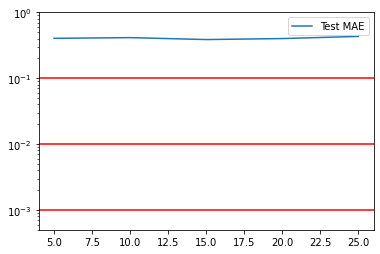

In [4]:
num_of_kernels = np.arange(5, 30, 5)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")

    rbf_2d = RBFNet(k=k, delta_epochs=500, cl_epochs=2)
    y_pred_train = rbf_2d.fit_and_predict(X_train, y_train, rule="delta", cl="hard")

    mae = rbf_2d.evaluate_residual_error(X_test, y_test)
    y_pred_test = rbf_2d.predict(X_test)

    print("Test MAE", mae)
    maes.append(mae)

best_k = np.argmin(maes)
print("Best", best_k, maes[best_k])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()

#display(pd.DataFrame(rbf_2d.kernel_centers, rbf_2d.kernel_stds))


In [9]:
mae_hard = []

for i in range(20):
    rbf_2d = RBFNet(k=13, delta_epochs=500, cl_epochs=300)
    y_pred_train = rbf_2d.fit_and_predict(X_train, y_train, rule="delta", cl="hard")

    mae = rbf_2d.evaluate_residual_error(X_test, y_test)
    y_pred_test = rbf_2d.predict(X_test)

    print("Test MAE", mae)
    mae_hard.append(mae)

print("Average MAE", sum(mae_hard)/len(mae_hard), np.std(mae_hard))

#display(pd.DataFrame(rbf_2d.kernel_centers, rbf_2d.kernel_stds))


Converged at epoch 277
After Train - MAE:  0.3628426676524461
Test MAE 0.3904481747564657
Converged at epoch 315
After Train - MAE:  0.38062935401736964
Test MAE 0.39107104212787874
Converged at epoch 291
After Train - MAE:  0.35490690460476315
Test MAE 0.3919852132081218
Converged at epoch 282
After Train - MAE:  0.3397192085011234
Test MAE 0.4142908565750314
Converged at epoch 217
After Train - MAE:  0.36019304071347097
Test MAE 0.39447822293499457
Converged at epoch 191
After Train - MAE:  0.3337044104632145
Test MAE 0.39031140345146403
Converged at epoch 214
After Train - MAE:  0.3703764140722632
Test MAE 0.3976870267256304
Converged at epoch 285
After Train - MAE:  0.4788414120296395
Test MAE 0.45245668173224646
Converged at epoch 303
After Train - MAE:  0.3970908974285156
Test MAE 0.40950263773651674
Converged at epoch 254
After Train - MAE:  0.36267561435867335
Test MAE 0.3821849028322149
Converged at epoch 278
After Train - MAE:  0.3615996573524629
Test MAE 0.4021363392304576
C

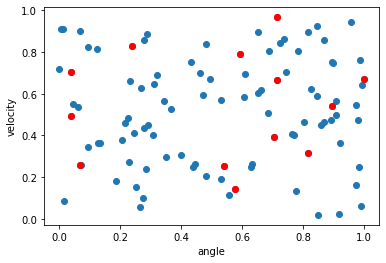

In [10]:
plt.scatter(data_train["angle"], data_train["velocity"])
plt.scatter(rbf_2d.kernel_centers[:, 0], rbf_2d.kernel_centers[:, 1], c="r")
plt.xlabel("angle")
plt.ylabel("velocity")
plt.show()


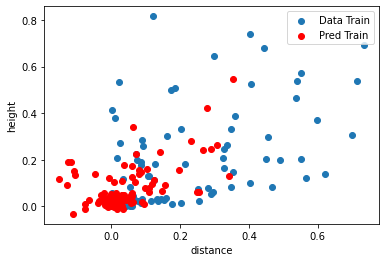

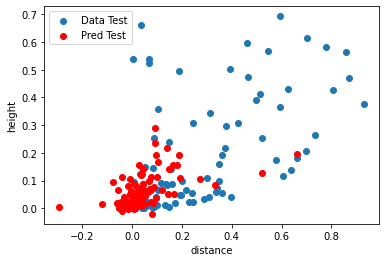

In [11]:
plt.scatter(data_train["distance"], data_train["height"], label="Data Train")
plt.scatter(y_pred_train[:, 0], y_pred_train[:, 1], c="r", label="Pred Train")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()

plt.scatter(data_test["distance"], data_test["height"], label="Data Test")
plt.scatter(y_pred_test[:, 0], y_pred_test[:, 1], c="r", label="Pred Test")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()


Converged at epoch 140
After Train - MAE:  0.4400181033276411
Test MAE 0.5380462539032079
Converged at epoch 190
After Train - MAE:  0.5055538498797562
Test MAE 0.48837434251438155
Converged at epoch 192
After Train - MAE:  0.5851262970558879
Test MAE 0.583955465609744
Converged at epoch 265
After Train - MAE:  0.4030785386095629
Test MAE 0.47543694217495275
Converged at epoch 291
After Train - MAE:  0.4228203643180766
Test MAE 0.44244541377930147
Converged at epoch 205
After Train - MAE:  0.40164063168619224
Test MAE 0.46709684092860826
Converged at epoch 222
After Train - MAE:  0.45668757130128057
Test MAE 0.5204600771151511
Converged at epoch 295
After Train - MAE:  0.5967116282838646
Test MAE 0.6036293285925917
Converged at epoch 249
After Train - MAE:  0.4350573486285999
Test MAE 0.47166580362773747
Converged at epoch 279
After Train - MAE:  0.41415644419861686
Test MAE 0.4540358756126946
Converged at epoch 422
After Train - MAE:  0.4360995013170658
Test MAE 0.44242214227161597
Co

,0,1
0.205514,0.869000,0.467000
0.071483,0.216000,0.462000
0.052681,0.159305,0.168145
0.002160,0.219791,0.677173
0.197995,0.497562,0.945138
0.137910,0.448737,0.701709
0.109647,0.252216,0.005091
0.285773,0.122884,0.676838
0.100467,0.651000,0.896000
0.030876,0.867000,0.857000


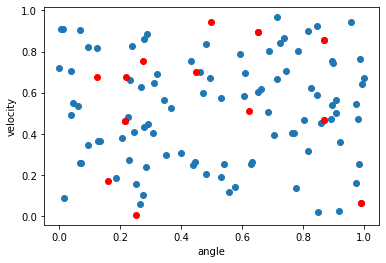

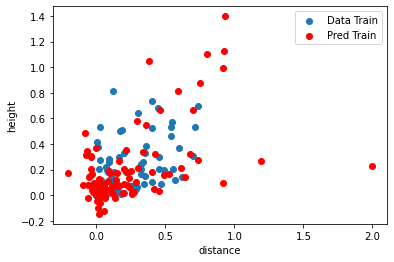

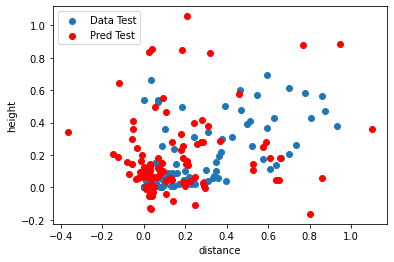

In [12]:
mae_bad = []

for i in range(20):
    rbf_2d = RBFNet(k=13, delta_epochs=500, cl_epochs=300)
    y_pred_train = rbf_2d.fit_and_predict(X_train, y_train, rule="delta", cl="bad")

    mae = rbf_2d.evaluate_residual_error(X_test, y_test)
    y_pred_test = rbf_2d.predict(X_test)

    print("Test MAE", mae)
    mae_bad.append(mae)

print("Average MAE", sum(mae_bad)/len(mae_bad), np.std(mae_bad))

display(pd.DataFrame(rbf_2d.kernel_centers, rbf_2d.kernel_stds))

plt.scatter(data_train["angle"], data_train["velocity"])
plt.scatter(rbf_2d.kernel_centers[:, 0], rbf_2d.kernel_centers[:, 1], c="r")
plt.xlabel("angle")
plt.ylabel("velocity")
plt.show()

plt.scatter(data_train["distance"], data_train["height"], label="Data Train")
plt.scatter(y_pred_train[:, 0], y_pred_train[:, 1], c="r", label="Pred Train")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()

plt.scatter(data_test["distance"], data_test["height"], label="Data Test")
plt.scatter(y_pred_test[:, 0], y_pred_test[:, 1], c="r", label="Pred Test")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()


Converged at epoch 155
After Train - MAE:  0.5190012103587945
Test MAE 0.46581242467027184
Converged at epoch 232
After Train - MAE:  0.5670733100461893
Test MAE 0.5758107327308969
Converged at epoch 179
After Train - MAE:  0.6193950766345101
Test MAE 0.6655348024515274
Converged at epoch 293
After Train - MAE:  0.5926538154031971
Test MAE 0.6034684216896268
Converged at epoch 231
After Train - MAE:  0.5289040753753088
Test MAE 0.5821961915368682
Converged at epoch 105
After Train - MAE:  0.5741264891301842
Test MAE 0.5915711438154448
Converged at epoch 223
After Train - MAE:  0.4096434163416483
Test MAE 0.46423952591261725
Converged at epoch 96
After Train - MAE:  0.5323608921756277
Test MAE 0.539765812588782
Converged at epoch 37
After Train - MAE:  0.526181349065911
Test MAE 0.6005570294854841
Converged at epoch 293
After Train - MAE:  0.48163945693679155
Test MAE 0.5205928229391598
Converged at epoch 404
After Train - MAE:  0.555060015517807
Test MAE 0.5675751785068855
Converged at

,0,1
0.189038,0.319505,0.740764
0.111773,0.172252,0.386819
0.137086,0.966718,0.721608
0.174774,0.832788,0.424115
0.069207,0.676760,0.854289
0.171758,0.879150,0.586452
0.081968,0.230415,0.138492
0.028453,0.634335,0.627322
0.120123,0.507929,0.243709
0.375183,0.038915,0.835731


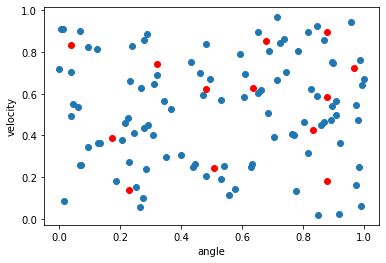

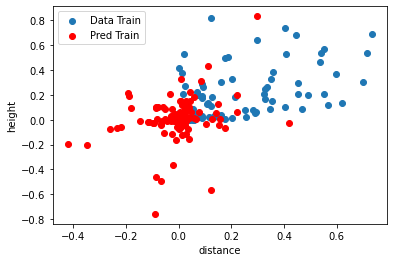

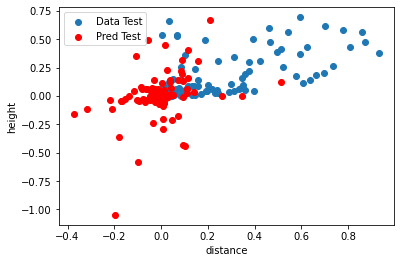

In [23]:
mae_soft = []

for i in range(20):
    rbf_2d = RBFNet(k=13, delta_epochs=500, cl_epochs=300)
    y_pred_train = rbf_2d.fit_and_predict(X_train, y_train, rule="delta", cl="soft")

    mae = rbf_2d.evaluate_residual_error(X_test, y_test)
    y_pred_test = rbf_2d.predict(X_test)

    print("Test MAE", mae)
    mae_soft.append(mae)

print("Average MAE", sum(mae_soft)/len(mae_soft), np.std(mae_soft))

display(pd.DataFrame(rbf_2d.kernel_centers, rbf_2d.kernel_stds))

plt.scatter(data_train["angle"], data_train["velocity"])
plt.scatter(rbf_2d.kernel_centers[:, 0], rbf_2d.kernel_centers[:, 1], c="r")
plt.xlabel("angle")
plt.ylabel("velocity")
plt.show()

plt.scatter(data_train["distance"], data_train["height"], label="Data Train")
plt.scatter(y_pred_train[:, 0], y_pred_train[:, 1], c="r", label="Pred Train")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()

plt.scatter(data_test["distance"], data_test["height"], label="Data Test")
plt.scatter(y_pred_test[:, 0], y_pred_test[:, 1], c="r", label="Pred Test")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()
plt.show()
